In [1]:
import numpy as np
import pandas as pd
import requests

- Get the time series for the following cryptocurrencies from `cryptowat.ch` starting from 2021-11-22, hourly data
    1. ETH
    2. SOL
    3. AVAX
    4. USDT
    5. FLOW

In [2]:
def get_data(token):
    if token == 'FLOW':
        exchange = 'kraken'
    else:
        exchange = 'coinbase-pro'
    result = requests.get(f'https://api.cryptowat.ch/markets/{exchange}/{token}usd/ohlc',
                         params={'periods': '3600',
                                 'after': str(int(pd.Timestamp('2021-11-22').timestamp()))
                                },
                          timeout=10
                         )
    df = pd.DataFrame(result.json()['result']['3600'],
                     columns=['ts','open','high','low','close','volume','volumeUSD'])
    df['ts'] = pd.to_datetime(df.ts, unit='s')
    df['token'] = token
    
    return df

In [3]:
tokens = ['ETH','SOL','AVAX','USDT','FLOW']

In [4]:
dfs = [get_data(token) for token in tokens]

In [5]:
df = pd.concat(dfs)

In [6]:
df.head()

,ts,open,high,low,close,volume,volumeUSD,token
0,2021-11-22 00:00:00,4317.98,4342.24,4246.07,4262.99,7262.562789,3.123077e+07,ETH
1,2021-11-22 01:00:00,4263.04,4270.34,4212.45,4234.37,8437.946084,3.574586e+07,ETH
2,2021-11-22 02:00:00,4234.87,4246.72,4171.17,4217.89,9259.725370,3.895639e+07,ETH
3,2021-11-22 03:00:00,4217.88,4223.48,4163.58,4193.47,9259.899519,3.882032e+07,ETH
4,2021-11-22 04:00:00,4192.95,4213.59,4147.00,4168.35,7934.546906,3.315476e+07,ETH


In [7]:
df.tail()

,ts,open,high,low,close,volume,volumeUSD,token
516,2021-12-13 12:00:00,9.017,9.127,9.000,9.124,26130.079295,236559.118484,FLOW
517,2021-12-13 13:00:00,9.126,9.299,9.123,9.130,36156.486241,332335.772990,FLOW
518,2021-12-13 14:00:00,9.131,9.131,8.995,9.035,33930.957700,307616.864368,FLOW
519,2021-12-13 15:00:00,9.034,9.036,8.851,8.892,21271.339724,189629.132673,FLOW
520,2021-12-13 16:00:00,8.892,8.892,8.748,8.806,11090.771107,98126.338366,FLOW


- Get the total USD volume traded for each token in a dataframe, sorted from highest volume to lowest volume

In [8]:
df.groupby('token')['volumeUSD'].sum().sort_values(ascending=False)

token
ETH     2.014065e+10
SOL     6.586254e+09
AVAX    3.325960e+09
USDT    1.915401e+09
FLOW    8.376490e+07
Name: volumeUSD, dtype: float64

- Add a column that calculates the close price ratio between ETH and SOL for each house (i.e. close price of ETH / close price of SOL for each period)

In [9]:
ETH_df, SOL_df = dfs[0], dfs[1]
ETH2SOL_s = ETH_df.set_index('ts').close / SOL_df.set_index('ts').close
ETH2SOL_s.name = 'ETH2SOL'
ETH2SOL_s

ts
2021-11-22 00:00:00    18.471694
2021-11-22 01:00:00    18.736150
2021-11-22 02:00:00    18.577985
2021-11-22 03:00:00    18.794937
2021-11-22 04:00:00    18.891059
                         ...    
2021-12-13 12:00:00    23.916885
2021-12-13 13:00:00    23.959647
2021-12-13 14:00:00    24.186603
2021-12-13 15:00:00    24.126092
2021-12-13 16:00:00    24.153299
Name: ETH2SOL, Length: 521, dtype: float64

In [10]:
df_addcolumn = df.join(ETH2SOL_s, on='ts')
df_addcolumn.head()

,ts,open,high,low,close,volume,volumeUSD,token,ETH2SOL
0,2021-11-22 00:00:00,4317.98,4342.24,4246.07,4262.99,7262.562789,3.123077e+07,ETH,18.471694
1,2021-11-22 01:00:00,4263.04,4270.34,4212.45,4234.37,8437.946084,3.574586e+07,ETH,18.736150
2,2021-11-22 02:00:00,4234.87,4246.72,4171.17,4217.89,9259.725370,3.895639e+07,ETH,18.577985
3,2021-11-22 03:00:00,4217.88,4223.48,4163.58,4193.47,9259.899519,3.882032e+07,ETH,18.794937
4,2021-11-22 04:00:00,4192.95,4213.59,4147.00,4168.35,7934.546906,3.315476e+07,ETH,18.891059


- Change the name of the `volume` and `volumeUSD` columns to `volumeBase` and `volumeTerm`

In [11]:
df_changename = df.rename(columns={'volume':'volumeBase','volumeUSD': 'volumeTerm'})
df_changename.head()

,ts,open,high,low,close,volumeBase,volumeTerm,token
0,2021-11-22 00:00:00,4317.98,4342.24,4246.07,4262.99,7262.562789,3.123077e+07,ETH
1,2021-11-22 01:00:00,4263.04,4270.34,4212.45,4234.37,8437.946084,3.574586e+07,ETH
2,2021-11-22 02:00:00,4234.87,4246.72,4171.17,4217.89,9259.725370,3.895639e+07,ETH
3,2021-11-22 03:00:00,4217.88,4223.48,4163.58,4193.47,9259.899519,3.882032e+07,ETH
4,2021-11-22 04:00:00,4192.95,4213.59,4147.00,4168.35,7934.546906,3.315476e+07,ETH


- create a fat table indexed by the timestamp, and each column is the close price of each token (i.e. this should be a table of  200 rows and 5 columns)

In [12]:
close_df = pd.concat([token_df.set_index('ts')[['close']].rename(columns={'close':token}) for token, token_df in zip(tokens, dfs)], axis=1)
close_df.head()

,ETH,SOL,AVAX,USDT,FLOW
ts,,,,,
2021-11-22 00:00:00,4262.99,230.785,128.67,1.0012,14.150
2021-11-22 01:00:00,4234.37,226.000,134.85,1.0013,13.621
2021-11-22 02:00:00,4217.89,227.037,132.54,1.0012,13.753
2021-11-22 03:00:00,4193.47,223.117,133.38,1.0011,13.652
2021-11-22 04:00:00,4168.35,220.652,136.29,1.0009,13.581


- calculate the hour by hour log return of the close price of each token (return is calculated by np.log(price_t / price_{t-1}))

In [13]:
ret_df = np.log(close_df.pct_change() + 1)
ret_df.head()

,ETH,SOL,AVAX,USDT,FLOW
ts,,,,,
2021-11-22 00:00:00,NaN,NaN,NaN,NaN,NaN
2021-11-22 01:00:00,-0.006736,-0.020952,0.046912,0.0001,-0.038102
2021-11-22 02:00:00,-0.003900,0.004578,-0.017279,-0.0001,0.009644
2021-11-22 03:00:00,-0.005806,-0.017417,0.006318,-0.0001,-0.007371
2021-11-22 04:00:00,-0.006008,-0.011109,0.021583,-0.0002,-0.005214


- \[Stretch\] calculate the correlation of the tokens using the table above

In [14]:
ret_df.corr()

,ETH,SOL,AVAX,USDT,FLOW
ETH,1.000000,0.738589,0.642973,-0.116452,0.556528
SOL,0.738589,1.000000,0.622458,0.109445,0.442153
AVAX,0.642973,0.622458,1.000000,-0.015941,0.384755
USDT,-0.116452,0.109445,-0.015941,1.000000,-0.195512
FLOW,0.556528,0.442153,0.384755,-0.195512,1.000000


- \[Stretch\] visualize the correlation in a matplotlib plot

In [15]:
import matplotlib.pyplot as plt

<Figure size 432x288 with 0 Axes>

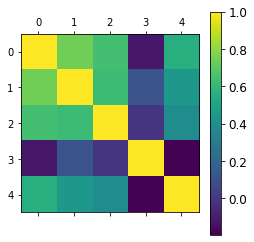

In [16]:
fig = plt.figure()
plt.matshow(ret_df.corr())
cb = plt.colorbar()
cb.ax.tick_params(labelsize=12)
plt.show()

A better way:

In [17]:
import seaborn as sns

<AxesSubplot:>

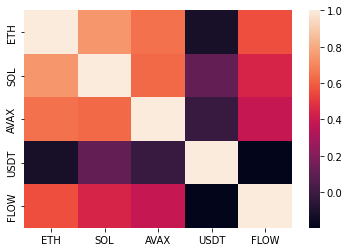

In [18]:
sns.heatmap(ret_df.corr())